In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns

In [70]:
NITEM = 3
MAXINV = 5
NSTATES = MAXINV**NITEM
PRODUCTION = 1
GAMMA = 0.95

In [19]:
def create_single_transition_prob_matrix(demand_pmf, production):
    demand_max = len(demand_pmf)-1
    demand_pmf = np.pad(np.flip(demand_pmf),(production,MAXINV-1))/np.sum(demand_pmf)
    rolled = np.zeros((MAXINV,len(demand_pmf)))
    rolled[0,:] = demand_pmf
    for i in range(1,MAXINV):
        rolled[i,1:] = rolled[i-1,:-1]
    tok = rolled[:,demand_max:demand_max+MAXINV]
    tok[:,0] += np.sum(rolled[:,:demand_max],1)
    tok[:,-1] += np.sum(rolled[:,demand_max+MAXINV:],1)
    assert np.allclose(np.sum(tok,1),1)
    return tok

In [24]:
from scipy.linalg import toeplitz
#demand_pmf = np.asarray([2,3,1])/6
demand_pmf = np.asarray([1,1,1])/3

def constructPI():
    # La matriciona Pi soi può ottenere con il prodotto di kronecker.
    # token[1] indica la matrice di transizione con solo un item e azione "non fare nulla", mentre token[0] con azione "ordinare"
    # La posizione nel kron indica se ordinare o no l'item i-esimo

    demand_pmf = np.asarray([1,2,1])
    tok_null = create_single_transition_prob_matrix(demand_pmf,0)
    tok_action = create_single_transition_prob_matrix(demand_pmf,PRODUCTION)

    PI = np.zeros((NITEM+1,NSTATES,NSTATES)) #cambio notazione pi(i,a,j) -> pi(a,i,j)
    for a in range(NITEM+1):
        PI[a] = reduce(np.kron, [tok_null if i != a else tok_action for i in range(NITEM)])
    assert np.allclose(PI.sum(2),1)
    return PI

def constructF():
    F = np.zeros((NITEM+1,NSTATES))
    for action in range(NITEM+1):
        for i in range(NSTATES):
            
            state = list(np.unravel_index(i,tuple([MAXINV]*NITEM)))
            # Applico l'azione
            # TODO: aggiungere costo ordine: F[action,i] += ...
            if action == NITEM:
                #do nothing
                pass
            else:
                #production
                state[action] += PRODUCTION

            # I costi sono lineari e le domande indipendenti
            for item in range(NITEM):
                for demand, prob in enumerate(demand_pmf):
                    unmet_demand = -min(state[item]-demand,0)
                    assert unmet_demand >= 0
                    newstate = np.clip(state[item]-demand,0,MAXINV)
                    cost = 3*unmet_demand + newstate
                    F[action,i] += cost*prob
    return F

In [61]:
3*constructF()[-1]

array([18., 13., 12., 15., 18., 13.,  8.,  7., 10., 13., 12.,  7.,  6.,
        9., 12., 15., 10.,  9., 12., 15., 18., 13., 12., 15., 18.])

In [71]:
F = (3*constructF())
assert np.allclose(F,F.round().astype(int))
F = F.round().astype(int)
for f in F:
    print('{',end='')
    for ff in f:
        print(ff,end=',')
    print('},',end='')


{22,17,16,19,22,17,12,11,14,17,16,11,10,13,16,19,14,13,16,19,22,17,16,19,22,21,16,15,18,21,16,11,10,13,16,15,10,9,12,15,18,13,12,15,18,21,16,15,18,21,24,19,18,21,24,19,14,13,16,19,18,13,12,15,18,21,16,15,18,21,24,19,18,21,24,27,22,21,24,27,22,17,16,19,22,21,16,15,18,21,24,19,18,21,24,27,22,21,24,27,30,25,24,27,30,25,20,19,22,25,24,19,18,21,24,27,22,21,24,27,30,25,24,27,30,},{22,17,16,19,22,21,16,15,18,21,24,19,18,21,24,27,22,21,24,27,30,25,24,27,30,17,12,11,14,17,16,11,10,13,16,19,14,13,16,19,22,17,16,19,22,25,20,19,22,25,16,11,10,13,16,15,10,9,12,15,18,13,12,15,18,21,16,15,18,21,24,19,18,21,24,19,14,13,16,19,18,13,12,15,18,21,16,15,18,21,24,19,18,21,24,27,22,21,24,27,22,17,16,19,22,21,16,15,18,21,24,19,18,21,24,27,22,21,24,27,30,25,24,27,30,},{22,21,24,27,30,17,16,19,22,25,16,15,18,21,24,19,18,21,24,27,22,21,24,27,30,17,16,19,22,25,12,11,14,17,20,11,10,13,16,19,14,13,16,19,22,17,16,19,22,25,16,15,18,21,24,11,10,13,16,19,10,9,12,15,18,13,12,15,18,21,16,15,18,21,24,19,18,21,24,27,14,13,

In [45]:
from itertools import product


[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [31]:
1-demand_pmf

array([0.66666667, 0.66666667, 0.66666667])

In [27]:
def assess_policy(policy):
    idxs = np.arange(NSTATES)
    fmu = F[policy[idxs],idxs]
    pimu = PI[policy[idxs],idxs,:]
    assert np.allclose(pimu.sum(1),1)
    return np.linalg.solve(np.eye(NSTATES)-GAMMA*pimu,fmu)
    print(fmu.shape, pimu.shape)

In [28]:
#a == NITEM -> a is action "do nothing"
PI = constructPI() #cambio notazione pi(i,a,j) -> pi(a,i,j)
F = constructF() #cambio notazione f(i,a) -> f(a,i)
V = np.zeros(NSTATES)

EPS = 1e-10
MAXITER = 4000

k = 0
while k < MAXITER:
    VNEW = np.min(F+GAMMA*PI.dot(V),0)
    if np.allclose(V,VNEW, atol = EPS, rtol = 0):
        V = VNEW
        break
    else:
        k = k+1
    V = VNEW
mu_opt = np.argmin(F+GAMMA*PI.dot(V),0)


print(k)
print(mu_opt.reshape([MAXINV]*NITEM))
print(np.allclose(V,assess_policy(mu_opt)))

470
[[0 0 0 0 0]
 [1 0 0 2 2]
 [1 1 2 2 2]
 [1 2 2 2 2]
 [1 2 2 2 2]]
True


[]

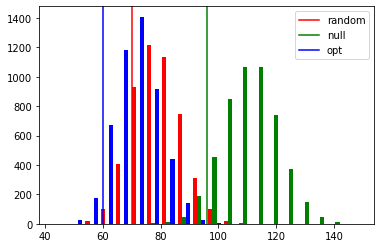

In [36]:
def simulate_policy(policy, startidx):
    costs = []
    for replica in range(5000):
        state = list(np.unravel_index(startidx,tuple([MAXINV]*NITEM)))
        cost = 0
        for t in range(100):
            idx = np.ravel_multi_index(tuple(state),tuple([MAXINV]*NITEM))
            action = policy[idx]
            
            if action == NITEM:
                #do nothing
                pass
            else:
                #production
                state[action] += PRODUCTION
            
            #random demand
            demand = np.random.choice([0,1,2],NITEM)

            state -= demand
            unmet_demand = -np.clip(state,-np.inf,0).sum()
            assert unmet_demand >= 0
            state = np.clip(state,0,MAXINV-1)
            assert ((GAMMA**t)*(3*unmet_demand+state.sum())) >= 0
            cost += (GAMMA**t)*(3*unmet_demand+state.sum())
        costs.append(cost)
    return costs

null_policy = np.ones(NSTATES, dtype=np.int32)*NITEM
random_policy = np.random.choice(list(range(NITEM+1)),NSTATES)
plt.hist([simulate_policy(random_policy,24),simulate_policy(null_policy,24),simulate_policy(mu_opt,24)],color=['r','g','b'],bins=20)
plt.axvline(assess_policy(random_policy)[-1],color = 'r')
plt.axvline(assess_policy(null_policy)[-1],color = 'g')
plt.axvline(assess_policy(mu_opt)[-1],color = 'b')
plt.legend(labels = ['random','null','opt'])
plt.plot()